In [6]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12,8
plt.style.use('fivethirtyeight')

In [7]:
dataset = pd.read_csv('AirPassengers.csv')
dataset['Month'] = pd.to_datetime(dataset['Month'], infer_datetime_format=True)
indexedDataset = dataset.set_index('Month')

In [8]:
indexedDataset.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [11]:
indexedDataset.tail()

,#Passengers
Month,
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390
1960-12-01,432


# Check Stationarity of Data

##### If checked mean of 1950 < mean of 1960, indicating that data is not stationary

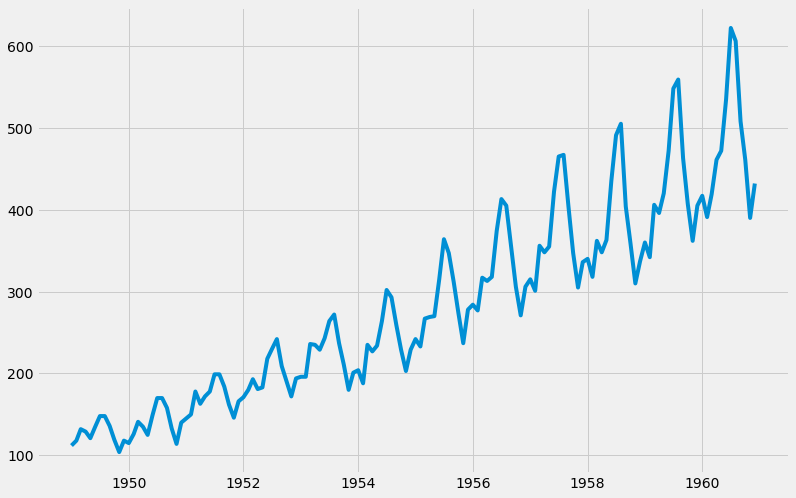

In [9]:
plt.plot(indexedDataset)

### Check by Rolling Statistics

##### From Rolling mean plot, its confirmed that data is on increasing trend and is not stationary

In [16]:
rolmean = indexedDataset.rolling(window=12).mean()
rolstd = indexedDataset.rolling(window=12).std()

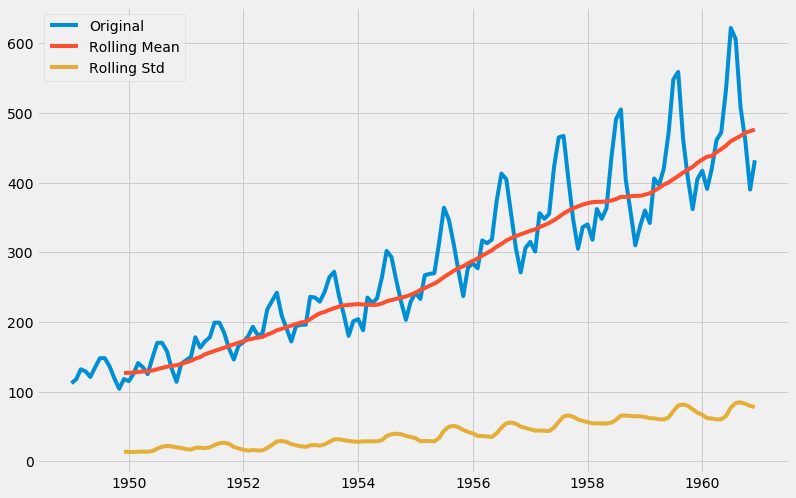

In [17]:
orig = plt.plot(indexedDataset, label='Original')
mean = plt.plot(rolmean, label='Rolling Mean')
std = plt.plot(rolstd, label='Rolling Std')
plt.legend(loc='best')

### Check by Dickey-Fuller Test

##### From Rolling mean plot, its confirmed that data is on increasing trend and is not stationary
##### p-Value should be around 0.5 and Critical Value should similar to Test Statistic to indicate data is stationary


In [19]:
from statsmodels.tsa.stattools import adfuller

In [22]:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(indexedDataset['#Passengers'], autolag='AIC')
# Akaike information criterion (AIC) is a mathematical method for evaluating how well a model fits the data it was generated from

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-Value',
                                        '# Lags Used', 'Num of Obs Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic            0.815369
p-Value                   0.991880
# Lags Used              13.000000
Num of Obs Used         130.000000
Critical Value (1%)      -3.481682
Critical Value (5%)      -2.884042
Critical Value (10%)     -2.578770
dtype: float64


# Estimate Trend on Log Scale

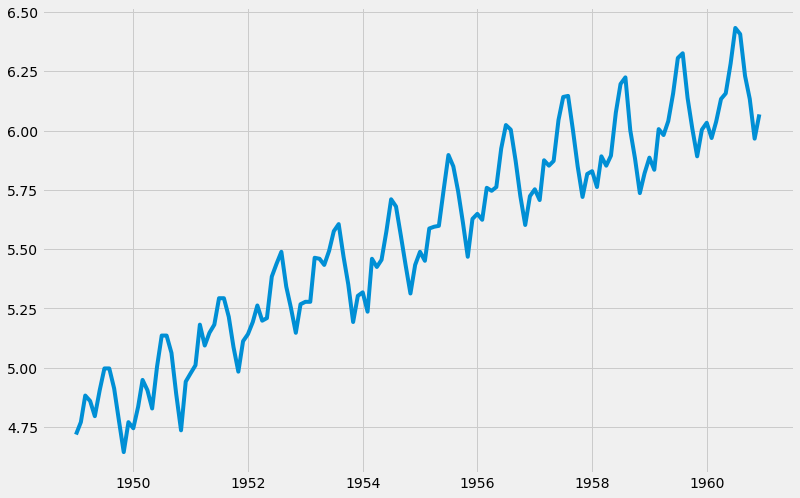

In [23]:
indexedDataset_logScale = np.log(indexedDataset)
plt.plot(indexedDataset_logScale)

#### Plotting on log scale along wih moving avg of log scale, Data again indicates it is not stationary

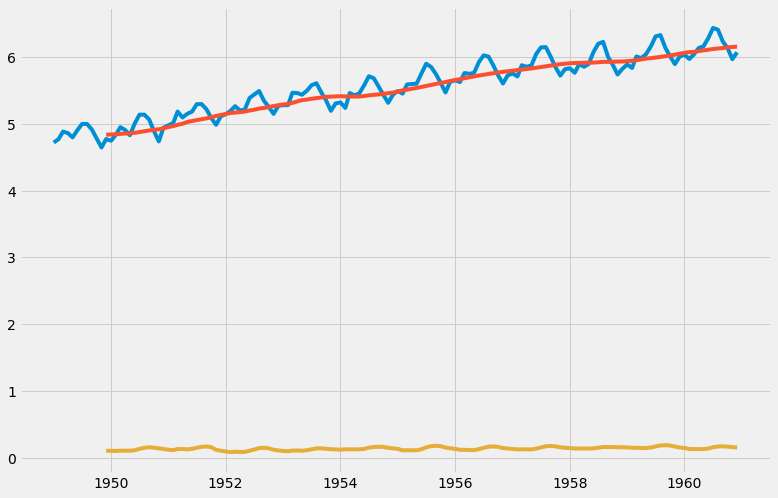

In [24]:
movingAverage = indexedDataset_logScale.rolling(window=12).mean()
movingSTD = indexedDataset_logScale.rolling(window=12).std()

plt.plot(indexedDataset_logScale)
plt.plot(movingAverage)
plt.plot(movingSTD)

# Function Check Stationarity and perform ADCF Test (Augmented Dickey Fuller Test)

In [26]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    # Determing Rolling Stats
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    # Plot Rolling  Stats
    orig = plt.plot(timeseries, label='Original')
    mean = plt.plot(movingAverage, label='Rolling Mean')
    std = plt.plot(movingSTD, label='Rolling Std')
    plt.legend(loc='best')
    
    # Perform Dickey Fuller Test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries['#Passengers'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-Value',
                                            '# Lags Used', 'Num of Obs Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value

    print(dfoutput)

# Convert Time Series to Stationary

In [25]:
datasetLogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage

# Remove Null Values
datasetLogScaleMinusMovingAverage.dropna(inplace=True)
datasetLogScaleMinusMovingAverage.head()

,#Passengers
Month,
1949-12-01,-0.065494
1950-01-01,-0.093449
1950-02-01,-0.007566
1950-03-01,0.099416
1950-04-01,0.052142


## If we do Stationarity Test on LogScalledData - LogScalledMovingAvg
#### We observe p value is very less, Critical Value is almost equal to TestStatistic
#### From plot we see that data is almost at a constant trend
#### All above indicating that data is stationary now

Results of Dickey-Fuller Test:
Test Statistic           -3.162908
p-Value                   0.022235
# Lags Used              13.000000
Num of Obs Used         119.000000
Critical Value (1%)      -3.486535
Critical Value (5%)      -2.886151
Critical Value (10%)     -2.579896
dtype: float64


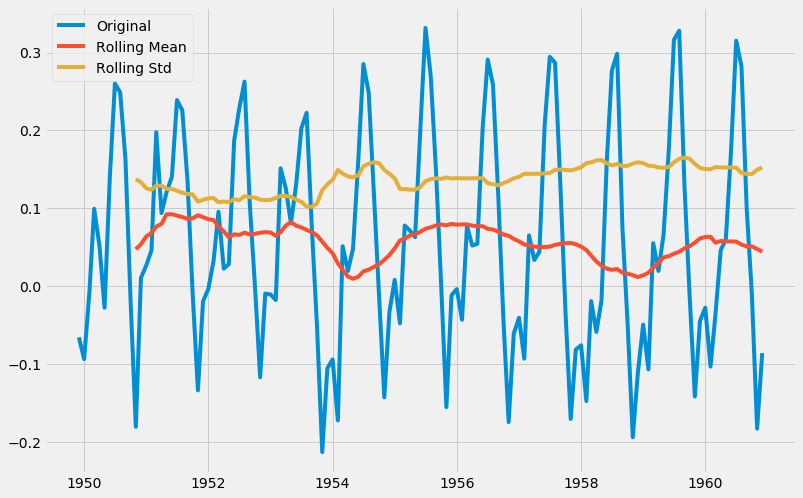

In [27]:
test_stationarity(datasetLogScaleMinusMovingAverage)

## Calculate Weighted Avg of Timeseries

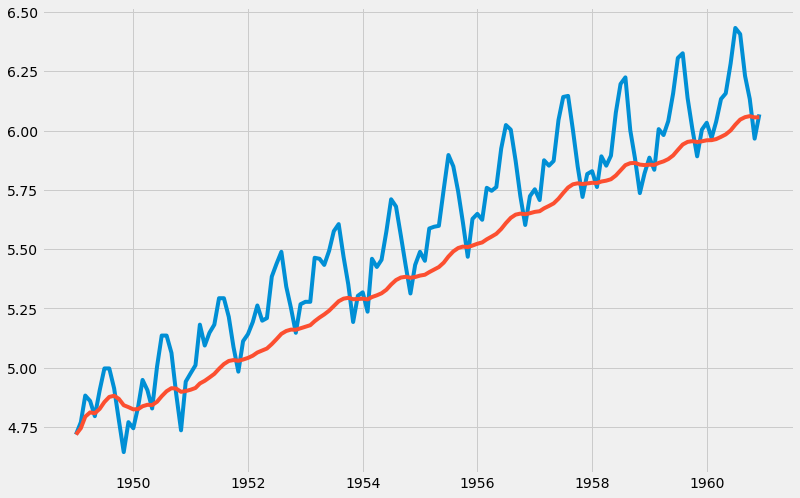

In [28]:
exponentialDecayWeightedAverage = indexedDataset_logScale.ewm(halflife=12,
                                                             min_periods=0,
                                                             adjust=True).mean()
plt.plot(indexedDataset_logScale)
plt.plot(exponentialDecayWeightedAverage)

Results of Dickey-Fuller Test:
Test Statistic           -3.601262
p-Value                   0.005737
# Lags Used              13.000000
Num of Obs Used         130.000000
Critical Value (1%)      -3.481682
Critical Value (5%)      -2.884042
Critical Value (10%)     -2.578770
dtype: float64


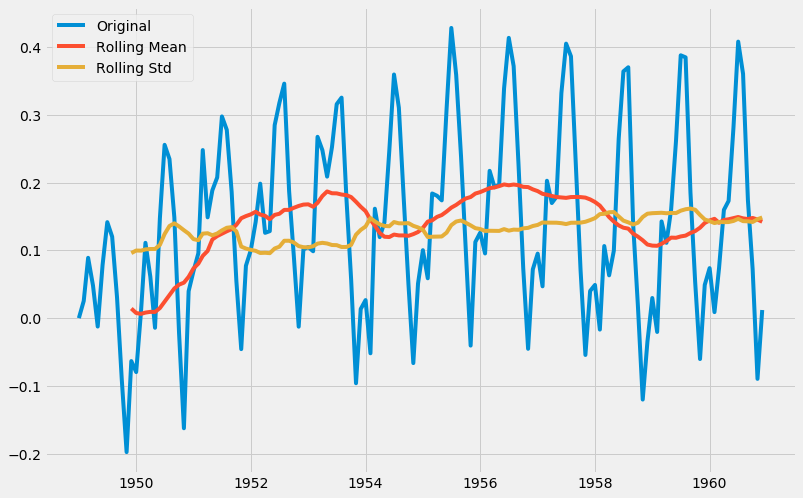

In [29]:
# Below calculated dataset is also stationary
datasetLogScaleMinusExponentialDecayWeightedAverage = indexedDataset_logScale - exponentialDecayWeightedAverage
test_stationarity(datasetLogScaleMinusExponentialDecayWeightedAverage)

## Shift LogScalled Values to get stationarity

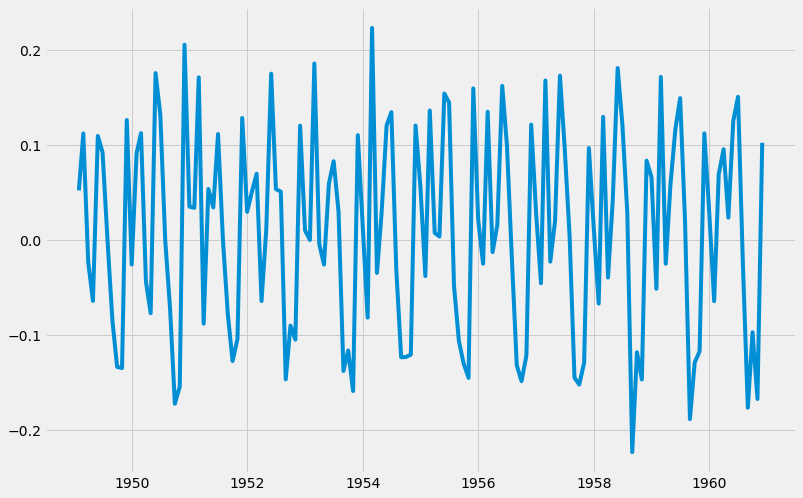

In [30]:
datasetLogDiffShifting = indexedDataset_logScale - indexedDataset_logScale.shift()
plt.plot(datasetLogDiffShifting)

Results of Dickey-Fuller Test:
Test Statistic           -2.717131
p-Value                   0.071121
# Lags Used              14.000000
Num of Obs Used         128.000000
Critical Value (1%)      -3.482501
Critical Value (5%)      -2.884398
Critical Value (10%)     -2.578960
dtype: float64


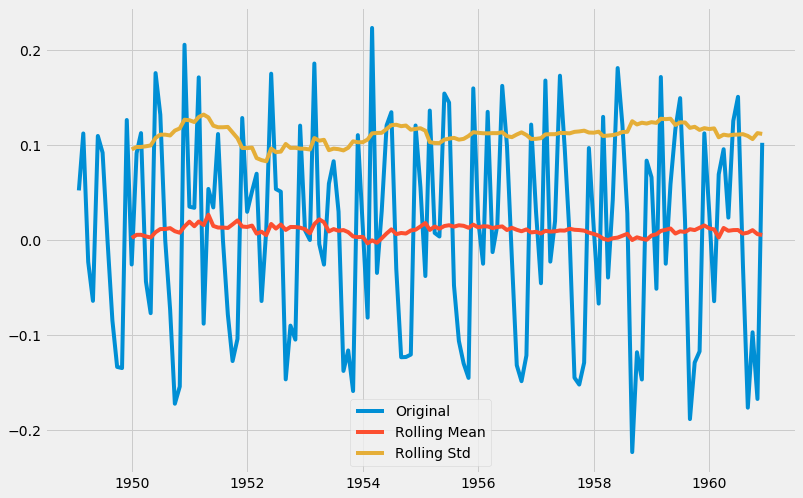

In [32]:
# Remove Null Values and test Stationarity
# Test indicates that Data is stationary
# Also since we did shifting once to make data stationary, so 'd'=1 in ARIMA
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)

# Decomposition of Time Series
#### Trend
#### Seasonality
#### Residual

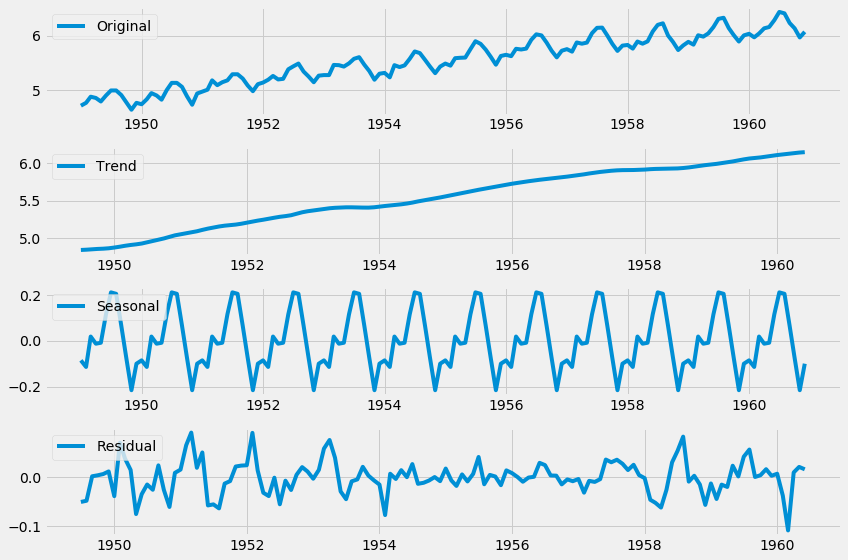

In [39]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(indexedDataset_logScale)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(indexedDataset_logScale, label = 'Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonal')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label = 'Residual')
plt.legend(loc='upper left')
plt.tight_layout()


Results of Dickey-Fuller Test:
Test Statistic         -6.332387e+00
p-Value                 2.885059e-08
# Lags Used             9.000000e+00
Num of Obs Used         1.220000e+02
Critical Value (1%)    -3.485122e+00
Critical Value (5%)    -2.885538e+00
Critical Value (10%)   -2.579569e+00
dtype: float64


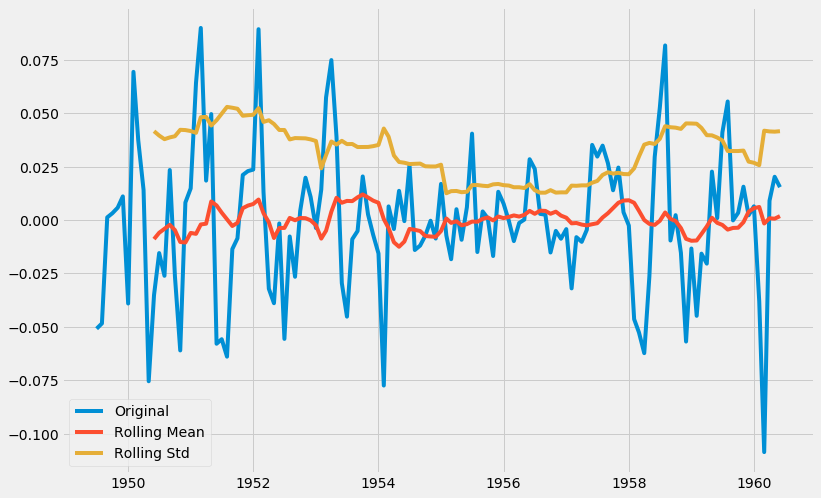

In [37]:
decomposedLogData = residual
decomposedLogData.dropna(inplace=True)
test_stationarity(decomposedLogData)

# Make ACF and PACF Plots to get values of p (AR part) and q (MA part)

In [40]:
from statsmodels.tsa.stattools import acf, pacf

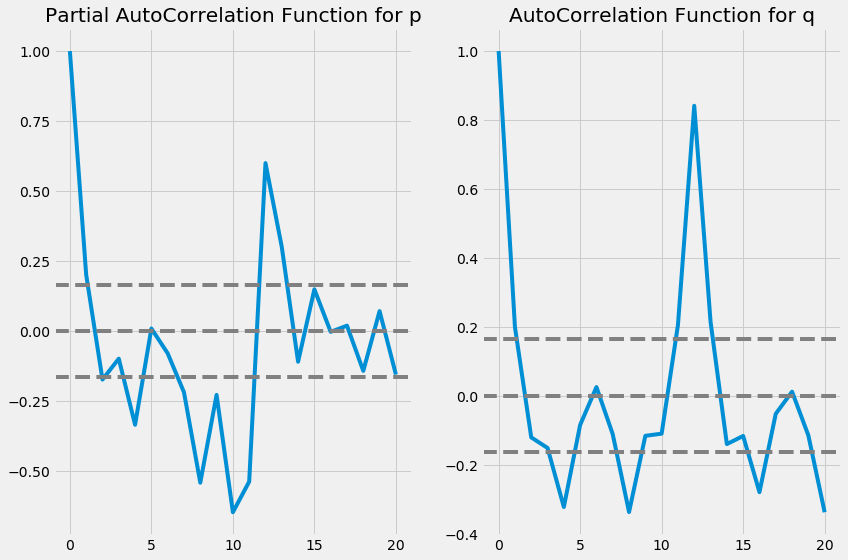

In [49]:
lag_acf = acf(datasetLogDiffShifting, nlags=20)
lag_pacf = pacf(datasetLogDiffShifting, nlags=20, method = 'ols')
# ols = ordinary least sqaure method

# Plot PACF
# Check where line drops to confidence level i.e. close to 0
# From below chart value of p=2
plt.subplot(121)
plt.plot(lag_pacf)
# Confidence Levels
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)),linestyle='--',color='gray')
plt.title('Partial AutoCorrelation Function for p')

# Plot ACF
# Check where line drops to confidence level i.e. close to 0
# From below chart value of d=2
plt.subplot(122)
plt.plot(lag_acf)
# Confidence Levels
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)),linestyle='--',color='gray')
plt.title('AutoCorrelation Function for q')
plt.tight_layout()

# Run ARIMA Model
##### p = 2 (From PACF graph)
##### d = 1 (From the count of shifting required to make data stationary)
##### q = 2 (From ACF Graph)

In [50]:
from statsmodels.tsa.arima_model import ARIMA

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 1.0292')

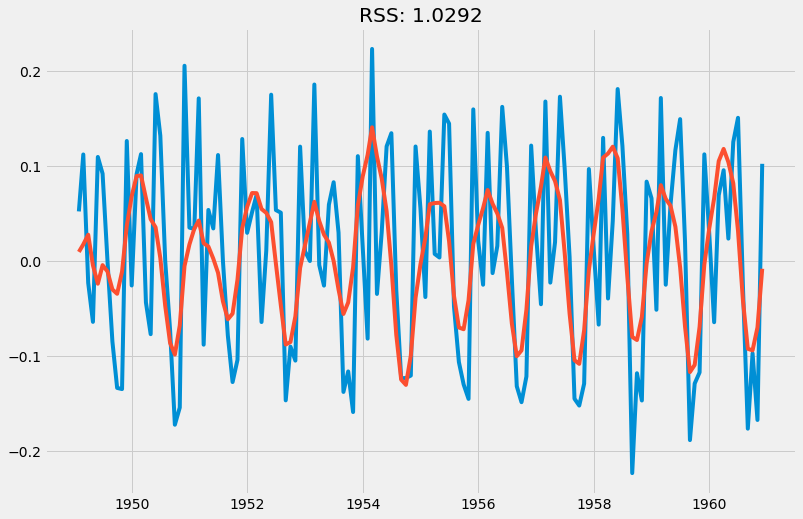

In [53]:
model = ARIMA(indexedDataset_logScale, order = (2,1,2) )
results_ARIMA = model.fit(disp=-1)

plt.plot(datasetLogDiffShifting)
plt.plot(results_ARIMA.fittedvalues)
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues - datasetLogDiffShifting['#Passengers'])**2))
# RSS = Residual sum of square, lower value is better

### Fit Model into Series

In [54]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64

### Convert Series to Cumulative Sum

In [55]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64

### Predictions done on 

In [71]:
predictions_ARIMA_log = pd.Series(indexedDataset_logScale['#Passengers'].ix[0],
                                 index = indexedDataset_logScale.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,
                                                 fill_value=0)
predictions_ARIMA_log.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

### Take Anti Log to get predicted data as per original data consistancy

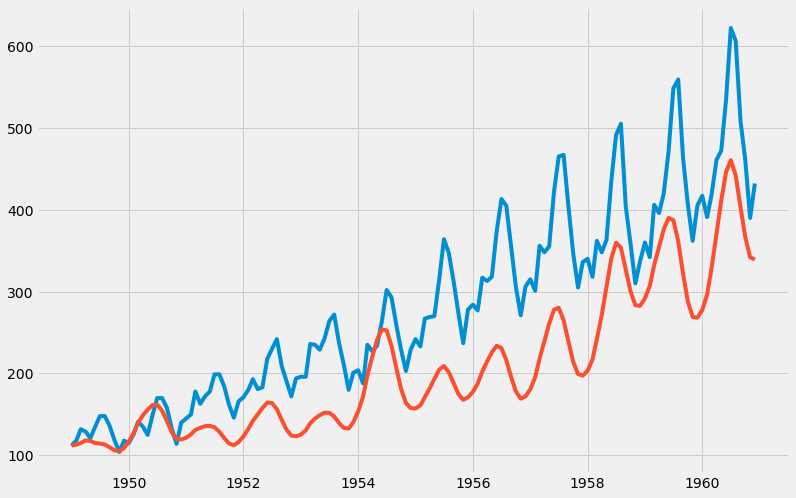

In [72]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(indexedDataset)
plt.plot(predictions_ARIMA)

# Calculate and Plot Future Predicted Values
#### Check number of datapoints in original dataset and then do prediction on (originalDataPoints + pointsRequiredInFuture)

In [73]:
indexedDataset.shape

(144, 1)

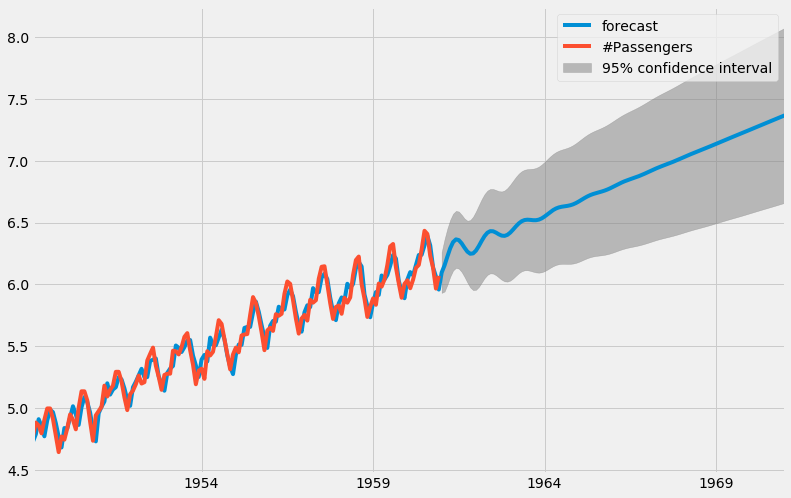

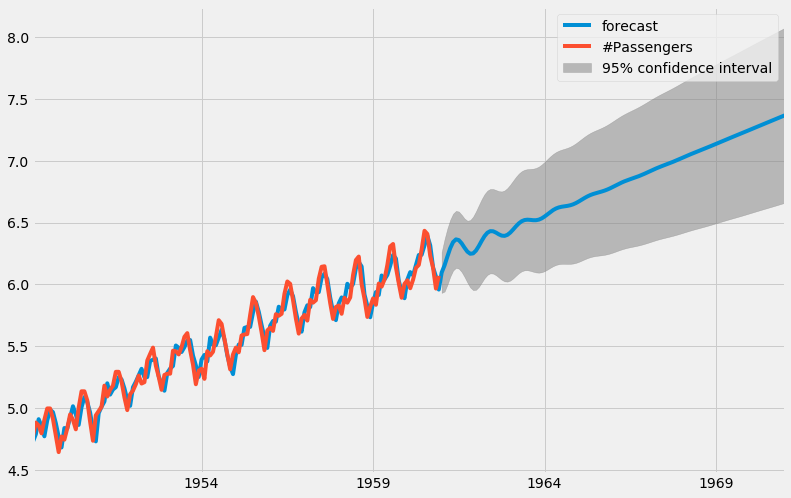

In [75]:
# Predict data for 10 Years, i.e. {10*12} 120 points
# Now totat data points will be {144+120} 264 points 
results_ARIMA.plot_predict(1,264)

# Run Model on Original Data

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 71748.6230')

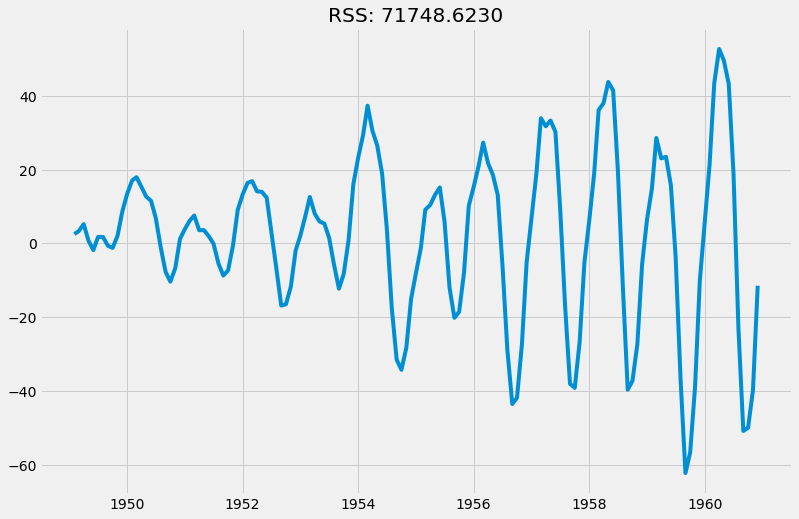

In [78]:
model = ARIMA(indexedDataset, order = (2,1,2) )
results_ARIMA = model.fit(disp=-1)

#plt.plot(datasetLogDiffShifting)
plt.plot(results_ARIMA.fittedvalues)
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues - datasetLogDiffShifting['#Passengers'])**2))
# RSS = Residual sum of square, lower value is better

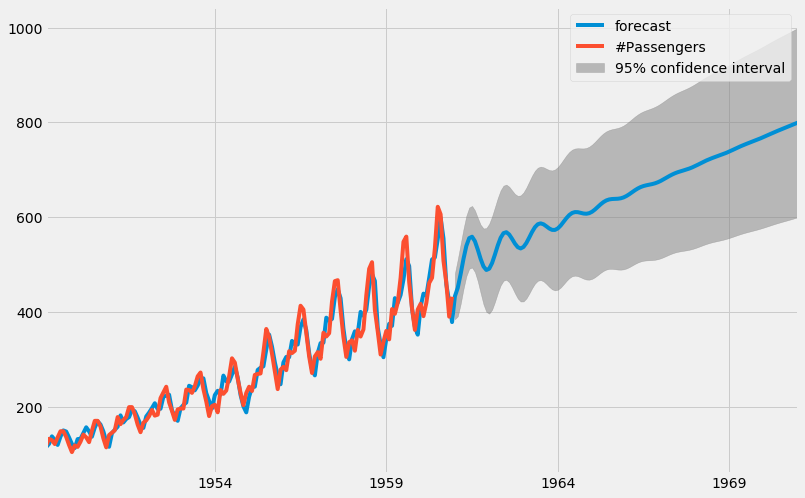

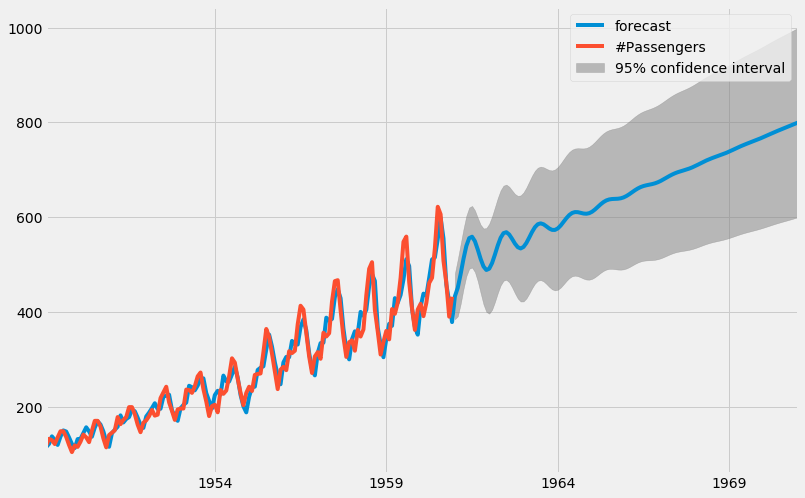

In [79]:
results_ARIMA.plot_predict(1,264)